# (공부) hf – lesson6:

최규빈  
2024-07-09

# 43

In [1]:
!pip install transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 모델 및 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.0 MB/s eta 0:00:00

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

# 44

In [2]:
import torch

# 감성 레이블을 숫자로 매칭하는 딕셔너리 준비
dic = {0:'positive', 1:'neutral', 2:'negative'}

# 입력 문장 데이터
eval_list = ["I like apple", "I like pear", "I go to school", "I dislike mosquito", "I felt very sad", "I feel so good"]

# 정답 레이블(answer label)
ans = torch.tensor([0, 0, 1, 2, 2, 0])


# 45

In [3]:
# 파인 튜닝 없는 상태에서의 추론
# 모델을 eval 모드로 전환
model.eval()

# 그래디언트(기울기) 계산 방지. eval 모드에서는 학습이 이뤄지지 않기에 이 조치가 필요
with torch.no_grad():
  for article in eval_list:

    # eval_list에 담긴 문장을 article이라는 변수에 하나씩 담아 토크나이저 인코딩
    inputs = tokenizer.encode(article, return_tensors="pt",padding=True, truncation=True)

    # 인코딩 결과를 모델에 투입
    outputs = model(inputs)

    # 로짓 추출
    logits = outputs.logits

    # 로짓의 최대값에 해당하는 인덱스를 추출하고, item( )을 통해 파이썬 숫자 형태로 변환
    # 결과적으로 위 숫자가 변수 dic에 담긴 인덱스가 되어 해당하는 문장의 감성을 출력
    print(f"{dic[logits.argmax(-1).item()]}:{article}")


positive:I like apple
positive:I like pear
positive:I go to school
neutral:I dislike mosquito
neutral:I felt very sad
neutral:I feel so good

#46

In [ ]:
# 런타임 1분 소요
# 활성화 함수 AdamW 불러오기
from transformers import AdamW

# 활성화 함수 AdamW 인스턴스화
optimizer = AdamW(model.parameters(), lr=1e-5)

# 모델을 학습 모드로 변경
model.train()

# 에포크 수 지정 및 손실을 담은 빈 컨테이너 리스트 생성
epochs = 50
losses = []

# 파인튜닝
for epoch in range(epochs):

    # 그래디언트(기울기) 초기화
    optimizer.zero_grad()

    # 변수 eval_list에 담긴 여섯 개 문장을 토크나이저에 넣고 인코딩
    inputs = tokenizer.batch_encode_plus(eval_list, return_tensors="pt", padding=True, truncation=True)

    # 위에서 생성된 input 변수에 담긴 키(key)와 키값(value)을 **inputs 형식(**kwargs 형식)으로 모델에 전달
    # 거기에 추가로 labels를 텐서 타입으로 모델에 전달
    outputs = model(**inputs, labels=ans)

    # 로짓 추출
    logits = outputs.logits

    # 손실 추출
    loss = outputs.loss

    # 오차역전파
    loss.backward()

    # 가중치(weight) 업데이트
    optimizer.step()

    # 손실을 빈 컨테이너 losses에 순서대로 저장
    losses.append(loss)

    # 에포크 및 손실 값 출력
    # 에포크는 0부터 시작하기에, 1을 더해줘서 사람들이 에포크 회수를 더 자연스럽게 인지하게 조치
    print(f"epoch:{epoch+1}, loss:{loss}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

epoch:1, loss:1.4317103624343872
epoch:2, loss:1.2873846292495728
epoch:3, loss:1.2401220798492432
epoch:4, loss:1.2557803392410278
epoch:5, loss:1.1766680479049683
epoch:6, loss:1.1615883111953735
epoch:7, loss:1.132081151008606
epoch:8, loss:1.1025440692901611
epoch:9, loss:1.1090829372406006
epoch:10, loss:0.9793352484703064
epoch:11, loss:1.006208896636963
epoch:12, loss:0.9385997653007507
epoch:13, loss:1.0793639421463013
epoch:14, loss:0.8481659889221191
epoch:15, loss:0.7109339833259583
epoch:16, loss:0.7423847317695618
epoch:17, loss:0.7727734446525574
epoch:18, loss:0.7216510772705078
epoch:19, loss:0.6911280155181885
epoch:20, loss:0.6055235266685486
epoch:21, loss:0.672376811504364
epoch:22, loss:0.5769751667976379
epoch:23, loss:0.6020018458366394
epoch:24, loss:0.6052810549736023
epoch:25, loss:0.5839531421661377
epoch:26, loss:0.5651684403419495
epoch:27, loss:0.4884357452392578
epoch:28, loss:0.48927226662635803
epoch:29, loss:0.5130942463874817
epoch:30, loss:0.50489956

# 47

In [ ]:
# 파이토치에서 item( )은 GPU로부터 값을 추출하여 CPU로 전달
new_losses = [i.item() for i in losses]

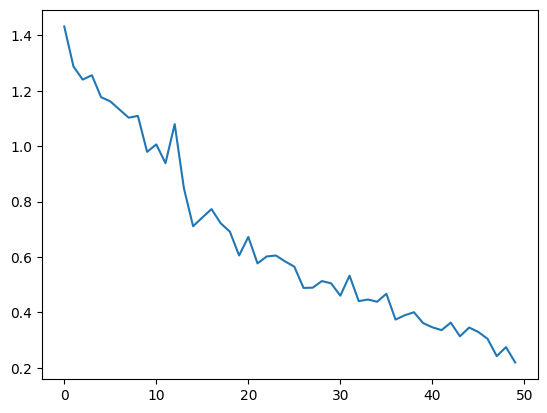

In [ ]:
import matplotlib.pyplot as plt
plt.plot(new_losses);


# 48

In [ ]:
# 파인 튜닝 이후 추론
dic = {0:'positive', 1:'neutral', 2:'negative'}
eval_list = ["I like apple", "I like pear", "I go to school", "I dislike mosquito", "I felt very sad", "I feel so good"]

# 모델을 eval 모델로 전환
model.eval()

# 모델 예측을 담을 preds라는 빈 컨테이너 리스트 생성
preds = []

# 이하 코드의 설명은 문제 45 코드 참조
with torch.no_grad():
  for article in eval_list:
    inputs = tokenizer.encode(article, return_tensors="pt",padding=True, truncation=True)
    outputs = model(inputs)
    logits = outputs.logits
    pred = logits.argmax(-1).item()
    preds.append(logits.argmax(-1).item())
    print(f"{dic[pred]}:{article}")


positive:I like apple
positive:I like pear
neutral:I go to school
negative:I dislike mosquito
negative:I felt very sad
positive:I feel so good

#49

In [ ]:

# item()에 의해 넘파이 숫자값이 된 preds를 다시 토치 텐서 타입으로 변환
import torch
preds = torch.tensor(preds)


In [ ]:
# preds 출력
preds

tensor([0, 0, 1, 2, 2, 0])

In [ ]:
# 정답(ans)와 예측(preds)가 일치하는 건수를
# 정답(ans)의 전체 건수로 나누어서 정확도(Accuracy) 계산
print(f"Accuracy:{100 * sum(ans.detach().clone()==preds)/len(ans.detach().clone())}%")

Accuracy:100.0%